In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf

from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LayerNormalization, MultiHeadAttention, Dropout, GlobalAveragePooling1D, Input

from keras_preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import itertools

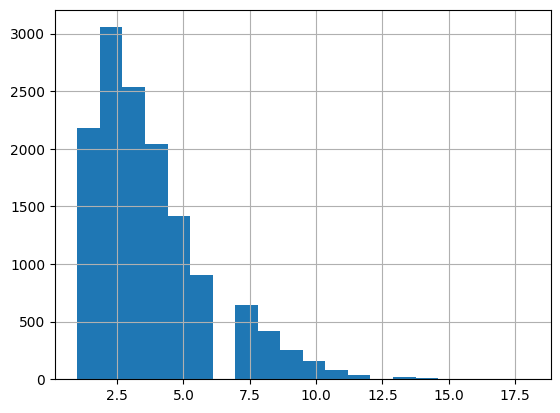

count    13761.000000
mean         3.640433
std          2.278675
min          1.000000
25%          2.000000
50%          3.000000
75%          5.000000
max         18.000000
Name: 0, dtype: float64


In [2]:
# import the data, display histogram of the length of the sentences
data = pd.read_csv('clean-data/clean-3-10-23.csv', header=None)
data = data.iloc[:, 0]

data.str.split().apply(len).hist(bins=20)
plt.show()
print(data.str.split().apply(len).describe())

data = data.str.split().apply(lambda x: x).values

In [3]:
tokens = data.tolist()
tokens = list(itertools.chain.from_iterable(data))

print(type(tokens))
print(tokens[:10])

<class 'list'>
['Open', 'lane!', 'Check', 'chat', 'logs', 'kick', 'her', 'fen', 'Some', 'lady']


In [4]:
given_words = 4
guess_words = 1

training_length = given_words + guess_words
text_sequences = []

for i in range(training_length, len(tokens)):
    seq = tokens[i-training_length:i]
    text_sequences.append(seq)

for i in range(given_words):
    print(' '.join(text_sequences[i]))

tokenizer = Tokenizer()
tokenizer.fit_on_texts(text_sequences)
sequences = tokenizer.texts_to_sequences(text_sequences)

# print(len(sequences[66]))

Open lane! Check chat logs
lane! Check chat logs kick
Check chat logs kick her
chat logs kick her fen


In [5]:
i = 0

vocabulary_size = len(tokenizer.word_counts) + 1
print(f"vocab size: {vocabulary_size}")

for a in tokenizer.index_word:
    print(a, "-->", tokenizer.index_word[a])
    i += 1

    if i == 10: break 

vocab size: 6371
1 --> you
2 --> to
3 --> i
4 --> me
5 --> the
6 --> fan
7 --> donate
8 --> u
9 --> can
10 --> my


In [6]:
sequences = np.array(sequences)
print(sequences.shape)

(50091, 5)


In [7]:
train_data = sequences[:, :-guess_words]
train_labels = sequences[:, -guess_words]

randomize = np.arange(len(train_data))
np.random.shuffle(randomize)

train_data = train_data[randomize]
train_labels = train_labels[randomize]

train_labels = to_categorical(train_labels, num_classes=vocabulary_size)

print(train_data.shape, train_labels.shape)

sequence_len = train_data.shape[1]
print(sequence_len)

(50091, 4) (50091, 6371)
4


In [8]:
class TokenAndPositionEmbedding(keras.layers.Layer):
    def __init__(self, maxlen, vocab_size, embed_dim):
        super().__init__()
        self.token_emb = keras.layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)
        self.pos_emb = keras.layers.Embedding(input_dim=maxlen, output_dim=embed_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

class Transformer(keras.layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(Transformer, self).__init__()

        self.att = MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = keras.Sequential(
            [Dense(ff_dim, activation="relu"), Dense(embed_dim),]
        )

        self.layernorm1 = LayerNormalization(epsilon=1e-6)
        self.layernorm2 = LayerNormalization(epsilon=1e-6)

        self.dropout1 = Dropout(rate)
        self.dropout2 = Dropout(rate)
    
    def call(self, inputs, training):
        attn_output = self.att(inputs, inputs)
        attn_output = self.dropout1(attn_output, training=training)

        out1 = self.layernorm1(inputs + attn_output)
        
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)


In [9]:
model = Sequential()

model.add(Input(shape=(sequence_len,)))

model.add(TokenAndPositionEmbedding(sequence_len, vocabulary_size, 25))

model.add(Transformer(25, 25, 25))
model.add(Dropout(0.2))
model.add(Transformer(25, 10, 25))
model.add(Dropout(0.2))
model.add(Transformer(25, 5, 25))

model.add(GlobalAveragePooling1D())

model.add(Dropout(0.2))
model.add(Dense(500, activation="sigmoid"))
model.add(Dropout(0.2))
model.add(Dense(vocabulary_size, activation="softmax"))

model.compile(
    loss='categorical_crossentropy', 
    optimizer='adam', 
    metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 token_and_position_embeddin  (None, 4, 25)            159375    
 g (TokenAndPositionEmbeddin                                     
 g)                                                              
                                                                 
 transformer (Transformer)   (None, 4, 25)             65800     
                                                                 
 dropout_2 (Dropout)         (None, 4, 25)             0         
                                                                 
 transformer_1 (Transformer)  (None, 4, 25)            27175     
                                                                 
 dropout_5 (Dropout)         (None, 4, 25)             0         
                                                                 
 transformer_2 (Transformer)  (None, 4, 25)            1

In [10]:
with tf.device("/device:GPU:0"):
    history = model.fit(
        train_data, train_labels, batch_size=128, epochs=25
    )

Epoch 1/25
392/392 [==============================] - 15s 25ms/step - loss: 6.9574 - accuracy: 0.0275
Epoch 2/25
392/392 [==============================] - 8s 19ms/step - loss: 6.7813 - accuracy: 0.0283
Epoch 3/25
392/392 [==============================] - 8s 20ms/step - loss: 6.7095 - accuracy: 0.0296
Epoch 4/25
392/392 [==============================] - 7s 19ms/step - loss: 6.6357 - accuracy: 0.0318
Epoch 5/25
392/392 [==============================] - 9s 24ms/step - loss: 6.5696 - accuracy: 0.0323
Epoch 6/25
392/392 [==============================] - 9s 24ms/step - loss: 6.5029 - accuracy: 0.0354
Epoch 7/25
392/392 [==============================] - 9s 24ms/step - loss: 6.4439 - accuracy: 0.0374
Epoch 8/25
392/392 [==============================] - 8s 19ms/step - loss: 6.3837 - accuracy: 0.0412
Epoch 9/25
392/392 [==============================] - 8s 20ms/step - loss: 6.3300 - accuracy: 0.0451
Epoch 10/25
392/392 [==============================] - 9s 24ms/step - loss: 6.2793 - accur

In [11]:
def generate_text(model, tokenizer, seq_len, seed_text, num_gen_words):
    output_text = []
    
    input_text = seed_text
    
    for i in range(num_gen_words):
        encoded_text = tokenizer.texts_to_sequences([input_text])[0]
        pad_encoded = pad_sequences([encoded_text], maxlen=seq_len, truncating='pre')
        
        predict_x = model.predict(pad_encoded, verbose=0) 
        pred_word_ind = np.argmax(predict_x, axis=1)[0]

        pred_word = tokenizer.index_word[pred_word_ind] 
        
        input_text += ' ' + pred_word
        
        output_text.append(pred_word)
        
    return ' '.join(output_text)

In [12]:
text = 'you look liked you'

new_text = generate_text(model, tokenizer, sequence_len, seed_text=text, num_gen_words=5)

print(f"{text}\033[91m {new_text}\033[00m")

print("------- generated text -------")
print(new_text)

you look liked you fan i donate me i
------- generated text -------
fan i donate me i


In [13]:
previous_text = 'i really like that'

for i in range(15):
    gen_text = generate_text(model, tokenizer, sequence_len, seed_text=previous_text, num_gen_words=5)

    print(f"{previous_text}\033[91m {gen_text}\033[00m")
    previous_text = gen_text

i really like that i donate me i donate
i donate me i donate me i donate me i
me i donate me i donate me i donate me
donate me i donate me i donate me i donate
i donate me i donate me i donate me i
me i donate me i donate me i donate me
donate me i donate me i donate me i donate
i donate me i donate me i donate me i
me i donate me i donate me i donate me
donate me i donate me i donate me i donate
i donate me i donate me i donate me i
me i donate me i donate me i donate me
donate me i donate me i donate me i donate
